In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
import scipy.stats

In [2]:
def fidelity_curves(JobAngles, BobFidelity, EveFidelity, degree):
    Model_Bob = np.poly1d(np.polyfit(JobAngles, BobFidelity, degree))
    Model_Eve = np.poly1d(np.polyfit(JobAngles, EveFidelity, degree))
    Thetas = np.linspace(0, np.pi/4, 100)
    Model_Bob_Curve = Model_Bob(Thetas)
    Model_Eve_Curve = Model_Eve(Thetas)
    return Thetas, Model_Bob_Curve, Model_Eve_Curve

In [3]:
def get_data(filename):
    Completed_Job_Data = pd.read_csv(filename)

    JobAngles = Completed_Job_Data.iloc[:, 1]
    BobFidelity = Completed_Job_Data.iloc[:, 11]
    EveFidelity = Completed_Job_Data.iloc[:, 12]

    JobAngles = np.array(JobAngles)
    BobFidelity = np.array(BobFidelity)
    EveFidelity = np.array(EveFidelity)
    
    return  JobAngles, BobFidelity, EveFidelity

In [4]:
def error_rate_theory(theta):
    return 0.5 - 0.5*np.sin(2 * theta)

In [5]:
def fidelity_curves_intersection(JobAngles, BobFidelity, EveFidelity, degree):
    Bob_coeffs, Bob_cov = np.polyfit(JobAngles, BobFidelity, degree, cov = True)
    Eve_coeffs, Eve_cov = np.polyfit(JobAngles, EveFidelity, degree, cov = True)
    
    Model_Bob = np.poly1d(Bob_coeffs)
    Model_Eve = np.poly1d(Eve_coeffs)
    #Model_Bob = np.poly1d(np.polyfit(JobAngles, BobFidelity, degree))
    #Model_Eve = np.poly1d(np.polyfit(JobAngles, EveFidelity, degree))
    
    Thetas = np.linspace(0, np.pi/4, 100)
    Model_Bob_curve = Model_Bob(Thetas)
    Model_Eve_curve = Model_Eve(Thetas)
    
    ModelDiff = Model_Bob - Model_Eve
    Roots = np.roots(ModelDiff)
    RealRoots = Roots[~np.iscomplex(Roots)]
    for j in range(len(RealRoots)):
        if RealRoots[j] >= 0 and RealRoots[j] <= np.pi/4:
            critical_theta = RealRoots[j]
            #critical_error =  error_rate_theory(critical_theta) 
            critical_error = 1 - Model_Bob(critical_theta)
            
    return critical_theta, critical_error, Thetas, Model_Bob_curve, Model_Eve_curve, Bob_cov, Eve_cov, Bob_coeffs, Eve_coeffs

In [6]:
def intersection_stats(Bob_sigma, Bob_coeffs, Eve_sigma, Eve_coeffs, N):
    k = len(Bob_sigma)
    theta_vals = np.zeros(N)
    error_vals = np.zeros(N)
    
    # select coeffs for Bob
    Bob0 = np.random.normal(Bob_coeffs[0], Bob_sigma[0], N)
    Bob1 = np.random.normal(Bob_coeffs[1], Bob_sigma[1], N)
    Bob2 = np.random.normal(Bob_coeffs[2], Bob_sigma[2], N)
    
    
    # select coeffs for Eve
    Eve0 = np.random.normal(Eve_coeffs[0], Eve_sigma[0], N)
    Eve1 = np.random.normal(Eve_coeffs[1], Eve_sigma[1], N)
    Eve2 = np.random.normal(Eve_coeffs[2], Eve_sigma[2], N)
    
    
    # build polynomails accordingly and find their intersection points
    for j in range(N):
        BobMod = np.array([Bob0[j], Bob1[j], Bob2[j]])
        EveMod = np.array([Eve0[j], Eve1[j], Eve2[j]])
        
        BobPoly = np.poly1d(BobMod)
        EvePoly = np.poly1d(EveMod)
        
        ModelDiff = BobPoly - EvePoly
        Roots = np.roots(ModelDiff)
        RealRoots = Roots[~np.iscomplex(Roots)]
        for k in range(len(RealRoots)):
            if RealRoots[k] >= 0 and RealRoots[k] <= np.pi/4:
                theta_vals[j] = RealRoots[k]
                error_vals[j] = 1 - BobPoly(RealRoots[k])
                        
    
    return theta_vals, error_vals

In [7]:
def mean_confidence_interval(data, confidence):
    N = len(data)
    mean = np.mean(data)
    std_error = scipy.stats.sem(data)
    h = std_error * scipy.stats.t.ppf((1 + confidence)/2., N-1)
    return mean, mean - h, mean + h

In [8]:
filename = 'Experiment_July15_2023_QPU_FullSize_Ybasis_bit1.csv'

In [9]:
JobAngles, BobFid, EveFid = get_data(filename)

In [10]:
theta_crit, error_crit, Thetas, Model_Bob_curve, Model_Eve_curve, Bob_cov, Eve_cov, Bob_coeffs, Eve_coeffs = fidelity_curves_intersection(JobAngles, BobFid, EveFid, 2)

In [11]:
# values based on the intersection of plotted information curves
print('Critical angle = ', theta_crit)
print('pi/8 = ', np.pi/8)
print('Critical error = ', error_crit)
print('Theoretical prediction = ', 0.5 - 0.25 * np.sqrt(2))

Critical angle =  0.4103680032964426
pi/8 =  0.39269908169872414
Critical error =  0.17789997146940917
Theoretical prediction =  0.1464466094067262


In [12]:
BobFid_Theory = 0.5 + 0.5*np.sin(2*Thetas)
EveFid_Theory = 0.5 + 0.5*np.cos(2*Thetas)

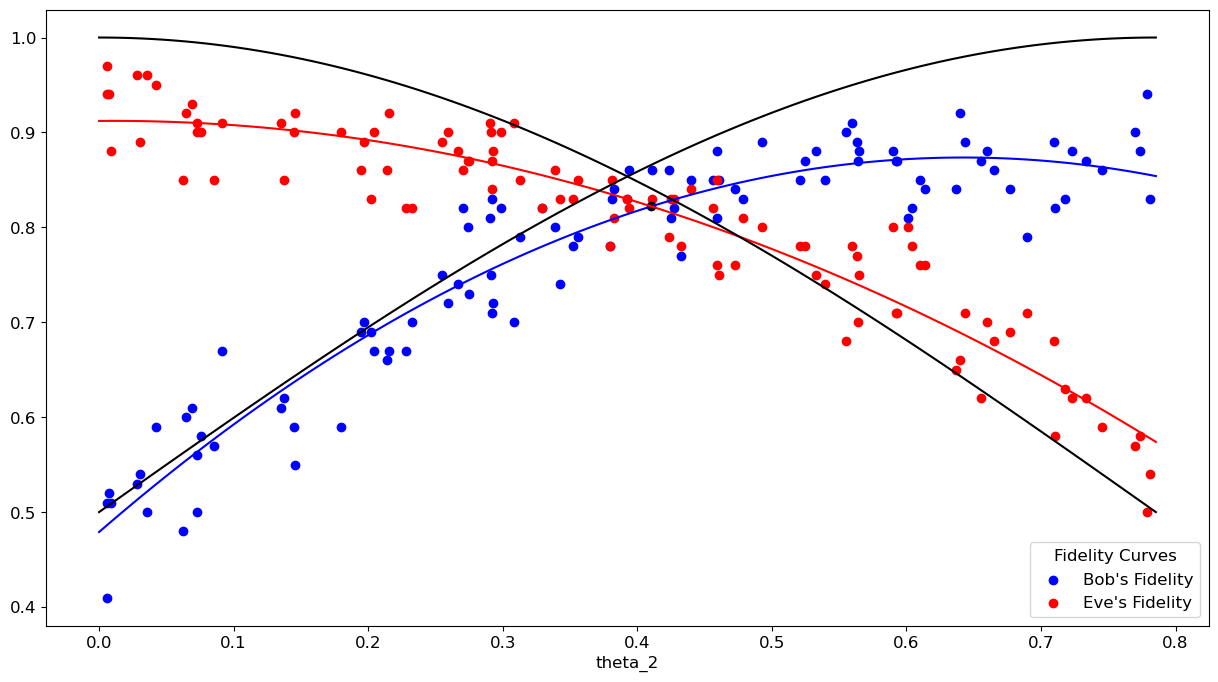

In [13]:
plt.figure(figsize=(15,8))
plt.rcParams.update({'font.size': 12})
plt.scatter(JobAngles, BobFid, label = "Bob's Fidelity",color='blue')
plt.scatter(JobAngles, EveFid, label = "Eve's Fidelity",color='red')
plt.scatter(theta_crit, 1- error_crit, color = 'black')
plt.plot(Thetas, Model_Bob_curve, color = 'blue')
plt.plot(Thetas, Model_Eve_curve, color = 'red')
plt.plot(Thetas, BobFid_Theory, color = 'black')
plt.plot(Thetas, EveFid_Theory, color = 'black')
#plt.yticks(np.arange(0,1.1, step = .1))
#plt.xticks(np.arange(-np.pi/2, 5*np.pi/8, step = np.pi/8))
plt.legend(title="Fidelity Curves")
plt.xlabel('theta_2')
plt.show()

In [14]:
Bob_sigma = np.sqrt(np.diag(Bob_cov))
Eve_sigma = np.sqrt(np.diag(Eve_cov))

In [15]:
theta_vals, error_vals = intersection_stats(Bob_sigma, Bob_coeffs, Eve_sigma, Eve_coeffs, 10000)

In [16]:
angle_confidence_interval = mean_confidence_interval(theta_vals, 0.95)
error_confidence_interval = mean_confidence_interval(error_vals, 0.95)

In [17]:
print(angle_confidence_interval)

(0.41685163308954104, 0.41574973931947484, 0.41795352685960724)


In [18]:
print(error_confidence_interval)

(0.1799640250548643, 0.1794871832121515, 0.1804408668975771)
